# Where's Waldo

In this Python Notebook we fine tune a pretrained ResNet18 model to find Waldo in a given unseen image. First, run the Setup cells to download and import the necessary libraries. To use this notebook for training a model, you must first download our augmented version of the Waldo data. If you would just like to find Waldo using a model, simply add the path to the checkpoint in the Training section and run the cells following that.

# Setup

Code in the following cells imports necessary libraries, mounts to your Google Drive, and sets all the global variables

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms, models
from torchvision.io import read_image
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import matplotlib.pyplot as plt

# Libraries for tiling images
!pip install image_slicer
!pip install imgaug

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


In [5]:
# Globals
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
BASE_PATH = '/gdrive/MyDrive/CSE455 Final Project/'
split_names = ["train", "validation", "test"]
categories = ["notwaldo", "waldo"]

# Hyperparameters
BATCH_SIZE = 128
TEST_BATCH_SIZE = 1
EPOCHS = 10
LEARNING_RATE = 0.0005
MOMENTUM = 0.9
PRINT_INTERVAL = 10
WEIGHT_DECAY = 0.001

# Experiment documentation - make sure to change this between runs to avoid overwriting checkpoints
EXPERIMENT_NUM = "0.13"
LOG_PATH = BASE_PATH + "logs/" + EXPERIMENT_NUM + "/"
LOAD_SAVED_CHECKPOINT = False

# Splitting data

Code in this section handles creating the train, validation, and test splits from a given dataset. 

In [6]:
# Loading data files and splitting them into train/validation/test
import os
import subprocess
import random

image_numbers = list(range(1,20))
print("image numbers before sampling:", image_numbers)
train_images = random.sample(image_numbers, 12)
for i in train_images:
  image_numbers.remove(i)
validation_images = random.sample(image_numbers, 3)
for i in validation_images:
  image_numbers.remove(i)
test_images = random.sample(image_numbers, 4)
for i in test_images:
  image_numbers.remove(i)
print("image numbers after sampling:", image_numbers)
image_numbers = list(range(1,20))
print("image numbers recreated:", image_numbers)
print("splits:", train_images, validation_images, test_images)

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
ORIGINAL_PATH = BASE_PATH + "waldo-data-organized/"

def get_splits(zipped=False, tarify=True):
  os.chdir(BASE_PATH)
  !ls
  if tarify:
    os.system("tar -cf " + os.path.join(BASE_PATH, "new_splits.tar") + " " + os.path.join(BASE_PATH, "new_splits/"))
  else:
    !tar -xvf "/gdrive/MyDrive/CSE455 Final Project/wheres_waldo/new_splits.tar" 

def duplicate_images(dir_path, label, times=1):
  """
  Args:
    dir_path: path to directory containing train, validation, and test splits
  """
  for split in split_names:
    picture_names = os.listdir(os.path.join(dir_path, split, label))
    print("before:", len(picture_names))
    for name in picture_names:
      for idx in range(times):
        subprocess.run(["cp", os.path.join(dir_path, split, label, name), os.path.join(dir_path, split, label, name[:-4] + "_d" + str(idx) + name[-4:])])
    print("after:", len(os.listdir(os.path.join(dir_path, split, label))))

def create_splits():
  # Create split folders
  if not os.path.exists(BASE_PATH + "new_splits/"):
    os.makedirs(BASE_PATH + "new_splits/train/waldo")
    os.makedirs(BASE_PATH + "new_splits/validation/waldo")
    os.makedirs(BASE_PATH + "new_splits/test/waldo")
    os.makedirs(BASE_PATH + "new_splits/train/notwaldo")
    os.makedirs(BASE_PATH + "new_splits/validation/notwaldo")
    os.makedirs(BASE_PATH + "new_splits/test/notwaldo")

  asterisk = "*"
  for image_num in train_images:
    os.chdir(ORIGINAL_PATH + str(image_num) + "/")
    !cp notwaldo/* '/gdrive/MyDrive/CSE455 Final Project/new_splits/train/notwaldo/'
    !cp waldo/* '/gdrive/MyDrive/CSE455 Final Project/new_splits/train/waldo/'
  for image_num in validation_images:
    os.chdir(ORIGINAL_PATH + str(image_num) + "/")
    !cp notwaldo/* '/gdrive/MyDrive/CSE455 Final Project/new_splits/validation/notwaldo/'
    !cp waldo/* '/gdrive/MyDrive/CSE455 Final Project/new_splits/validation/waldo/'
  for image_num in test_images:
    os.chdir(ORIGINAL_PATH + str(image_num) + "/")
    !cp notwaldo/* '/gdrive/MyDrive/CSE455 Final Project/new_splits/test/notwaldo/'
    !cp waldo/* '/gdrive/MyDrive/CSE455 Final Project/new_splits/test/waldo/'
  
print("Train waldo instances:")
os.chdir('/gdrive/MyDrive/CSE455 Final Project/new_splits/train/waldo/')
!ls | wc -l
print("Train notwaldo instances:")
os.chdir('/gdrive/MyDrive/CSE455 Final Project/new_splits/train/notwaldo/')
!ls | wc -l
print("Validation waldo instances:")
os.chdir('/gdrive/MyDrive/CSE455 Final Project/new_splits/validation/waldo/')
!ls | wc -l
print("Validation notwaldo instances:")
os.chdir('/gdrive/MyDrive/CSE455 Final Project/new_splits/validation/notwaldo/')
!ls | wc -l
print("Test waldo instances:")
os.chdir('/gdrive/MyDrive/CSE455 Final Project/new_splits/test/waldo/')
!ls | wc -l
print("Test notwaldo instances:")
os.chdir('/gdrive/MyDrive/CSE455 Final Project/new_splits/test/notwaldo/')
!ls | wc -l
os.chdir('/content')

image numbers before sampling: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
image numbers after sampling: []
image numbers recreated: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
splits: [10, 1, 14, 4, 17, 9, 7, 18, 16, 5, 11, 15] [12, 3, 19] [8, 2, 13, 6]
Train waldo instances:
867
Train notwaldo instances:
3514
Validation waldo instances:
248
Validation notwaldo instances:
759
Test waldo instances:
258
Test notwaldo instances:
1020


# Loading data

Now that the splits have been created or retreived, we can create the dataloaders for them. Note that each split currently uses a different type of dataloader.

In [36]:
# Image helper function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def peek_data(peek_dataloader):
  dataiter = iter(peek_dataloader)
  images, labels = dataiter.next()
  print("images", images.size())
  images = images[:8]
  print("labels", labels)

  # show images
  imshow(torchvision.utils.make_grid(images))
  # print labels
  print("Labels:" + ', '.join('%9s' % data['to_class'][labels[j].item()] for j in range(len(images))))

def peek_data_with_path(peek_dataloader, has_labels=False):
  # Show training data with non-filename dataset
  dataiter = iter(peek_dataloader)
  images, labels, paths = dataiter.next()
  print("images", images.size())
  images = images[:8]
  print("labels", labels.size())

  # show images
  imshow(torchvision.utils.make_grid(images))
  if has_labels:
    # print labels
    print("Labels:" + ', '.join('%9s' % data['to_class'][labels[j].item()] for j in range(len(images))))
  # print paths
  print("Path:", paths)

Training set size: 4381
Validation set size: 1007
Test set size: 1278
{'notwaldo': 0, 'waldo': 1}
images torch.Size([1, 3, 64, 64])
labels tensor([0])


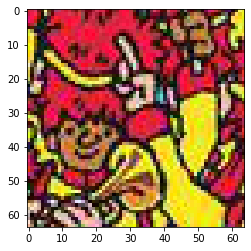

Labels: notwaldo


In [8]:
def get_waldo_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])
    trainset = datasets.ImageFolder(root=os.path.join(BASE_PATH, 'new_splits/train'), transform=transform_train)
    validationset = datasets.ImageFolder(root=os.path.join(BASE_PATH, 'new_splits/validation'), transform=transform_test)
    testset = datasets.ImageFolder(root=os.path.join(BASE_PATH, 'new_splits/test'), transform=transform_test)
    print("Training set size:", len(trainset))
    print("Validation set size:", len(validationset))
    print("Test set size:", len(testset))

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    validationloader = torch.utils.data.DataLoader(validationset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)

    class_to_idx = testset.class_to_idx
    print(class_to_idx)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    return {'train': trainloader, 'validation': validationloader, 'test': testloader, 'to_class': idx_to_class}

data = get_waldo_data()
peek_data(data['validation'])

['notwaldo', 'waldo']
images torch.Size([1, 3, 64, 64])
labels torch.Size([1])


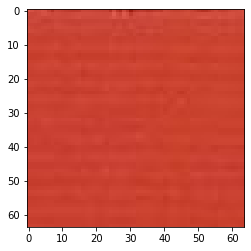

Labels: notwaldo
Path: ('/gdrive/MyDrive/CSE455 Final Project/new_splits/test/notwaldo/14_0_0.jpg',)


In [40]:
# Create ImageFolder which includes image path names
class WaldoImageFolder(datasets.folder.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None,
                 loader=datasets.folder.default_loader):
        super(WaldoImageFolder, self).__init__(root, transform, target_transform, loader)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target, path

# Optimize transforms for test set since we won't be using this for training
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

image_datasets = {x: WaldoImageFolder(os.path.join('/gdrive/MyDrive/CSE455 Final Project/new_splits', x),
                                          transform=data_transform)
                  for x in ['train', 'validation', 'test']}

# Optimize data loaders for test set since we won't be using this for training
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=TEST_BATCH_SIZE,
                                             shuffle=False, num_workers=2)
              for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}


class_names = image_datasets['train'].classes
print(class_names)

peek_data_with_path(dataloaders['test'], has_labels=True)

4381
images torch.Size([128, 3, 64, 64])
labels tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0])


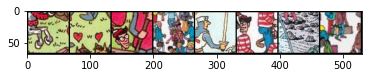

Labels: notwaldo,  notwaldo,     waldo,     waldo,  notwaldo,     waldo,  notwaldo,  notwaldo


In [16]:
# Create dataset with equal waldo and notwaldo images
class EqualRatioDataset(torch.utils.data.Dataset):
    def __init__(self, waldo_image_folder, notwaldo_image_folder, transform=None, target_transform=None):
        self.waldo_dir = waldo_image_folder
        self.waldo_images = os.listdir(waldo_image_folder)
        self.notwaldo_dir = notwaldo_image_folder
        self.notwaldo_images = os.listdir(notwaldo_image_folder)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.waldo_images) + len(self.notwaldo_images)

    def __getitem__(self, idx):
        # label key: {'notwaldo': 0, 'waldo': 1}
        if idx % 2 == 0:
            # when idx is even, pull the next waldo image
            image = read_image(os.path.join(self.waldo_dir, self.waldo_images[(idx // 2) % len(self.waldo_images)]))
            label = 1
        else:
            # when idx is odd, pull the next notwaldo image
            image = read_image(os.path.join(self.notwaldo_dir, self.notwaldo_images[idx // 2]))
            label = 0

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return torch.div(image, 255), label

# Training data only
duo_dataset = EqualRatioDataset('/gdrive/MyDrive/CSE455 Final Project/new_splits/train/waldo',
                                '/gdrive/MyDrive/CSE455 Final Project/new_splits/train/notwaldo') 
print(len(duo_dataset))

duo_loader = torch.utils.data.DataLoader(duo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
peek_data(duo_loader)

# Create model

In this section we create a CNN model with combinations of convolution, maxpool, and batch normalization layers. This model should be trained on ImageNet first before fine tuning on the Waldo dataset.

In [17]:
# Model creation code (torch.Module class)
class WaldoNet(nn.Module):
    def __init__(self):
        super(WaldoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1);
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1);
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1);
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(8192, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        # TODO define the forward pass
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.maxpool1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.maxpool3(x)
        x = self.batchnorm3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        return x

# Training

Here we are performing the training of the model and accuracy calculations. We are currently utilizing a ResNet18 model that has been pretrained on ImageNet. The model weights are mostly frozen - only the last fully connected layer is fine tuned with our Waldo dataset.

In [18]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.))

    # Filter out frozen (requres_grad=False) layers
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, momentum=momentum, weight_decay=decay)
    # optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
 
    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

def accuracy(net, dataloader):
  correct = 0
  positives = 0
  false_negative = 0
  false_positive = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          for idx, label in enumerate(labels):
            if label == 1:
              if predicted[idx] != label:
                false_negative += 1
              positives += 1
            else:
              if predicted[idx] != label:
                false_positive += 1

  print("Number of waldos guessed wrong:", false_negative)
  print("Total number of waldos:", positives)
  print("Number of notwaldos guessed wrong:", false_positive)
  print("Total correct:", correct)
  print("Total images:", total)
  return correct/total, false_negative/positives

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Training new model...
Learning rate: 0.000500
[0,    10] loss: 0.808
[0,    20] loss: 0.710
[0,    30] loss: 0.619
[1,    10] loss: 0.560
[1,    20] loss: 0.536
[1,    30] loss: 0.513
[2,    10] loss: 0.474
[2,    20] loss: 0.467
[2,    30] loss: 0.452
[3,    10] loss: 0.458
[3,    20] loss: 0.419
[3,    30] loss: 0.419
[4,    10] loss: 0.425
[4,    20] loss: 0.413
[4,    30] loss: 0.394
[5,    10] loss: 0.404
[5,    20] loss: 0.406
[5,    30] loss: 0.379
[6,    10] loss: 0.385
[6,    20] loss: 0.370
[6,    30] loss: 0.385
[7,    10] loss: 0.395
[7,    20] loss: 0.357
[7,    30] loss: 0.357
[8,    10] loss: 0.367
[8,    20] loss: 0.362
[8,    30] loss: 0.371
[9,    10] loss: 0.370
[9,    20] loss: 0.364
[9,    30] loss: 0.323
Number of waldos guessed wrong: 332
Total number of waldos: 2191
Number of notwaldos guessed wrong: 310
Total correct: 3739
Total images: 4381
Training accuracy: 0.853458114585711
Training false negatives: 0.1515289821999087

Number of waldos guessed wrong: 186
T

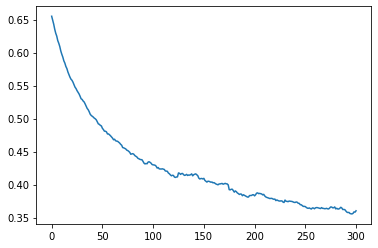

In [19]:
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

# net = WaldoNet()
model_ft = models.resnet18(pretrained=True)
model_ft.trainable = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

# Freeze all non-fully connected layer weights
for name, param in model_ft.named_parameters():
  if param.requires_grad and 'fc' not in name:
    param.requires_grad = False
model_ft = model_ft.to(device)

# Load model from checkpoint - make sure your path / file name / saved epoch are correct and consistent!
saved_state = None
saved_epoch = 0
if LOAD_SAVED_CHECKPOINT:
  print("Using saved checkpoint from", LOG_PATH)
  saved_state = torch.load(LOG_PATH + 'checkpoint-10.pkl')
  saved_epoch = 10
  print("Starting on epoch", saved_epoch)
else:
  print("Training new model...")

losses = train(model_ft, duo_loader, epochs=EPOCHS, lr=LEARNING_RATE, momentum=MOMENTUM, 
               decay=WEIGHT_DECAY, print_every=PRINT_INTERVAL, 
               schedule={0:LEARNING_RATE, 10:LEARNING_RATE / 10, 20:LEARNING_RATE / 20}, checkpoint_path=LOG_PATH, 
               start_epoch=saved_epoch, state=saved_state)
plt.plot(smooth(losses,50))

train_acc, train_fn = accuracy(model_ft, duo_loader)
print("Training accuracy:", train_acc)
print("Training false negatives:", train_fn)
print()

val_acc, val_fn = accuracy(model_ft, data['validation'])
print("Validation  accuracy:", val_acc)
print("Validation false negatives:", val_fn)

# Testing

In this section we run the trained model on our test set to gauge accuracy and generalizability to unseen data

In [20]:
# Running trained model on test set
test_acc, test_fn = accuracy(model_ft, data['test'])
print("Test accuracy:", test_acc)
print("Test false negatives:", test_fn)

Number of waldos guessed wrong: 188
Total number of waldos: 258
Number of notwaldos guessed wrong: 284
Total correct: 806
Total images: 1278
Test accuracy: 0.6306729264475743
Test false negatives: 0.7286821705426356


# Run model on an unseen image

Now that the model has been trained, we can use it on our own images! This section will take in a given image, tile it into 64x64 images, feed it into the model, and re-stitch the tiles together to highlight where Waldo was found in the image.

In [23]:
os.chdir(BASE_PATH)
import crop_utils

In [25]:
# Tile demo image
rows, columns = crop_utils.cropTiles(os.path.join(BASE_PATH, "demo_pictures", "waldo_snow.jpg"))
print("Rows:", rows)
print("Columns:", columns)

Cropping input image: /gdrive/MyDrive/CSE455 Final Project/demo_pictures/waldo_snow.jpg
Generating 64x64 tiles from original image...
Rows: 29
Columns: 46


images torch.Size([1, 3, 64, 64])
labels torch.Size([1])


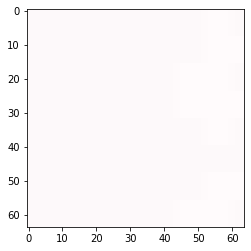

Path: ('temp_01_01.png',)


In [38]:
class DemoDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None,
                 loader=datasets.folder.default_loader):
        self.root_dir = root
        self.image_names = os.listdir(root)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
      return len(self.image_names)

    def __getitem__(self, index):
        # label key: {'notwaldo': 0, 'waldo': 1}
        image = read_image(os.path.join(self.root_dir, self.image_names[index]))
        label = -1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return torch.div(image, 255), label, self.image_names[index]

demo_data = DemoDataset(root=os.path.join(BASE_PATH, 'temp'))
demo_loader = torch.utils.data.DataLoader(demo_data, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)

# Show demo data with non-filename dataset
peek_data_with_path(demo_loader)

In [39]:
waldo_images = []
with torch.no_grad():
    for i, batch in enumerate(demo_data, 0):
        input, label, path = batch[0], batch[1], batch[2]
        input = torch.zeros([1, 3, 64, 64], dtype=torch.float)
        input[0] = batch[0]
        input = input.to(device)
        if i % 100 == 0:
            print("Processing image", i)
        outputs = model_ft(input)
        _, predicted = torch.max(outputs.data, 1)

        for idx, prediction in enumerate(predicted):
          if prediction == 1:
            waldo_images.append(path)

print("\nFound", len(waldo_images), "waldos!")
crop_utils.stitchTiles(rows, columns, waldo_images)

Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Processing image 1100
Processing image 1200
Processing image 1300

Found 397 waldos!
STITCHING TILES...
Deleting tiles...
Done
